In [107]:
# you need to install hmvec
# instructions here: https://github.com/simonsobs/hmvec

# Setup

In [1]:
import numpy as np
import scipy as scp
from scipy.special import eval_legendre, legendre, spherical_jn
import itertools
import time
from scipy import interpolate
from itertools import cycle
from math import atan2,degrees,lgamma 
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp2d,interp1d
import scipy.interpolate as si
from scipy.optimize import fsolve
import random
import os 

In [2]:
# you can ignore this one box

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

from mpl_toolkits.axes_grid1 import make_axes_locatable

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e'%x))
fmt = mticker.FuncFormatter(g)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

plt.rcParams.update({'backend' : 'Qt5Agg'})
plt.rcParams.update({'text.usetex' : True})

plt.rcParams.update({'font.size' : 15.0})
plt.rcParams.update({'axes.titlesize' : 20.0})  # Font size of title
plt.rcParams.update({'axes.titlepad'  : 10.0})
plt.rcParams.update({'axes.labelsize' : 20.0})  # Axes label sizes
plt.rcParams.update({'axes.labelpad'  : 10.0})
plt.rcParams.update({'xtick.labelsize'  : 20.0})
plt.rcParams.update({'ytick.labelsize'  : 20.0})
#plt.rcParams.update({'xtick.labelsize'  : 10.0})
#plt.rcParams.update({'ytick.labelsize'  : 10.0})

plt.rcParams.update({'axes.spines.left'  : True})
plt.rcParams.update({'axes.spines.right'  : True})
plt.rcParams.update({'axes.spines.top'  : True})
plt.rcParams.update({'axes.spines.bottom'  : True})
plt.rcParams.update({'savefig.format'     : 'pdf'})
plt.rcParams.update({'savefig.bbox'       : 'tight'})
plt.rcParams.update({'savefig.pad_inches' : 0.1})
plt.rcParams.update({'pdf.compression' : 6})

def plot_dmdz(ms, zs, func, count=10, title='No Title'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    c1, c2, g1, g2 = 0, 0, 0, 0
    for mi, mm in enumerate(ms):
        if mm in ms[:count]:
            ax[0].plot(zs, func[:,mi], linewidth=1, label=('$m=${}'.format(fmt(mm)) if mm in ms[:count//count] else None), alpha=1-c1/count, color='k')
            c1 += 1
        elif mm in ms[-count:]:
            ax[0].plot(zs, func[:,mi], linewidth=1, label=('$m=${}'.format(fmt(mm)) if mm in ms[-count//count:] else None), alpha=c2/count, color='g')
            c2 += 1
    for zi, zz in enumerate(zs):
        if zz in zs[:count]:
            ax[1].plot(ms, func[zi,:], linewidth=1, label=('$z=${}'.format(fmt(zz)) if zz in zs[:count//count] else None), alpha=1-g1/count, color='r')
            g1 += 1
        elif zz in zs[-count:]:
            ax[1].plot(ms, func[zi,:], linewidth=1, label=('$z=${}'.format(fmt(zz)) if zz in zs[-count//count:] else None), alpha=g2/count, color='b')
            g2 += 1

    ax[0].set_xlabel(r'$z$')
    ax[1].set_xlabel(r'$m$')
    for axx in ax:
        axx.set_yscale('log')
        axx.set_xscale('log')
        axx.set_ylabel(title)
        axx.legend(loc='best'); axx.grid()
    return ax

def plot_ucosth(ms, zs, angs, ucosth, prob, title, count=10):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    nMs, nZs = len(ms), len(zs)
    c1, c2, g1, g2 = 0, 0, 0, 0
    for mi, mm in enumerate(ms):
        if mm in ms[:count]:
            lab = lambda zi: (r'$m=${}'.format(fmt(mm))+f', $z=%5.2f$'%(zs[zi]) if mi==0 else None)
            zi = 0
            ax[0].plot(angs[:,zi,mi], ucosth[:,zi,mi], label=lab(zi), alpha=1-c1/count, color='k')
            c1 += 1
            zi = nZs-1
            ax[0].plot(angs[:,zi,mi], ucosth[:,zi,mi], label=lab(zi), alpha=1-c2/count, color='r')
            c2 += 1
        elif mm in ms[-count:]:
            lab = lambda zi: (r'$m=${}'.format(fmt(mm))+f', $z=%5.2f$'%(zs[zi]) if mi==len(ms)-1 else None)
            zi = 0
            ax[0].plot(angs[:,zi,mi], ucosth[:,zi,mi], label=lab(zi), alpha=g1/count, color='g')
            g1 += 1
            zi = nZs-1
            ax[0].plot(angs[:,zi,mi], ucosth[:,zi,mi], label=lab(zi), alpha=g2/count, color='b')
            g2 += 1

    c1, c2, g1, g2 = 0, 0, 0, 0
    for mi, mm in enumerate(ms):
        if mm in ms[:count]:
            lab = lambda zi: (r'$m=${}'.format(fmt(mm))+f', $z=%5.2f$'%(zs[zi]) if mi==0 else None)
            zi = 0
            ax[1].plot(angs[:,zi,mi], ucosth[:,zi,mi]*prob[zi,mi], label=lab(zi), alpha=1-c1/count, color='k')
            c1 += 1
            zi = nZs-1
            ax[1].plot(angs[:,zi,mi], ucosth[:,zi,mi]*prob[zi,mi], label=lab(zi), alpha=1-c2/count, color='r')
            c2 += 1
        elif mm in ms[-count:]:
            lab = lambda zi: (r'$m=${}'.format(fmt(mm))+f', $z=%5.2f$'%(zs[zi]) if mi==len(ms)-1 else None)
            zi = 0
            g1 += 1
            ax[1].plot(angs[:,zi,mi], ucosth[:,zi,mi]*prob[zi,mi], label=lab(zi), alpha=g1/count, color='g')
            zi = nZs-1
            ax[1].plot(angs[:,zi,mi], ucosth[:,zi,mi]*prob[zi,mi], label=lab(zi), alpha=g2/count, color='b')
            g2 += 1

    for axx in ax:
        axx.set_yscale('log')
        axx.set_xscale('log')
        axx.set_ylabel(r'$u(\cos(\theta)) \times Prob$')
        axx.set_xlabel(r'$\theta$')
        axx.legend(loc='best'); axx.grid()
    return ax


In [3]:
#import os,sys
#sys.path.append('../')
#sys.path.append('./hmvec-master/')
#import hmvec as hm


In [3]:
import hmvec as hm

# Functions

## Original functions

In [93]:
def get_rcross_per_halo(zs, ms, rs, rvir, rhocritz, deltav, cs, MA, name='battagliaAGN'):
    
    """ Compute crossing radius of each halo
    i.e. radius where plasma mass^2 = dark photon mass^2
    Find the index of the radius array where plasmon mass^2 = dark photon mass^2 """

    m200critz, r200critz = get_200critz(zs, ms, cs, rhocritz, deltav)
    rcross_res = np.zeros((len(zs), len(ms)))
    
    for i_z, z in enumerate(zs):
        for i_m, m in enumerate(ms):
            def func(x):
                return np.abs(conv*get_gas_profile(x, z, m200critz[i_z, i_m], r200critz[i_z, i_m], rhocritz[i_z])/MA**2. - 1)
            rcross_res[i_z, i_m] = fsolve(func, x0=rs[0])

    return rcross_res

In [94]:
# Functions to compute the useful stuff

get_volume_conv = lambda chis, Hz: chis**2. / Hz

def get_rcross_per_halo_old(zs, ms, rs, rvir, rhocritz, deltav, cs, MA, name='battagliaAGN'):
    """ Compute crossing radius of each halo
    i.e. radius where plasma mass^2 = dark photon mass^2
    Find the index of the radius array where plasmon mass^2 = dark photon mass^2 """

    m200critz, r200critz = get_200critz(zs, ms, cs, rhocritz, deltav)
    gas_profile = get_gas_profile(rs[None,None,:], zs[:,None,None], m200critz[...,None], 
                                  r200critz[...,None], rhocritz[:,None,None])
                 
    # to get from rho to MA multiply by conv
    return rs[np.argmin(np.abs(conv*gas_profile - MA**2.), axis=-1)]


def R_from_M(M,rho,delta):
    ''' Gives you halo radius from mass and overdensity'''
    return (3.*M/4./np.pi/delta/rho)**(1./3.) 

def get_200critz(zs, ms, cs, rhocritz, deltav):
    delta_rhos1 = deltav*rhocritz
    delta_rhos2 = 200.*rhocritz
    m200critz = hm.mdelta_from_mdelta(ms, cs, delta_rhos1, delta_rhos2)
    r200critz = R_from_M(m200critz, rhocritz[:,None], delta=200.)
    return m200critz, r200critz

def get_gas_profile(rs, zs, m200, r200, rhocritz):
    rho0, alpha, beta, gamma, xc = battagliaAGN(m200, zs)
    rho = rhocritz * rho0
    x = rs/r200/xc
    expo = -(beta+gamma)/alpha     # gamma sign must be opposite from Battaglia/ACT paper; typo

    return rho * (x**gamma) * ((1.+x**alpha)**expo)

def battagliaAGN(m200, zs):
    # power law fits:
    rho0  = 4000. * (m200/1e14)**0.29    * (1.+zs)**(-0.66)
    alpha = 0.88  * (m200/1e14)**(-0.03) * (1.+zs)**0.19
    beta  = 3.83  * (m200/1e14)**0.04    * (1.+zs)**(-0.025)
        
    gamma = -0.2
    xc    = 0.5
    return rho0, alpha, beta, gamma, xc

def conv_prob(zs, rvir, MA, rcross):
    omgz   = (1.+zs[:,None])# * omega0 but we want to keep frequency dependence separate
    uang  = 2.*np.heaviside(rvir - rcross, 0.5)
    return mpcEVinv * rcross * uang * omgz / MA**2.

def old_conv_prob(zs, ms, rs, rvir, rhocritz, deltav, cs, MA, rcross):
    m200, r200 = get_200critz(zs, ms, cs, rhocritz, deltav)
    drhodr = get_deriv_gas_profile(rcross, zs[:,None], m200, r200, rhocritz[:,None])
    dmdr   = np.abs(conv*drhodr)
    omgz   = (1.+zs[:,None])# * omega0 but we want to keep frequency dependence separate
    uang   = 2.*np.heaviside(rvir - rcross, 0.5)
    return mpcEVinv * uang * omgz / dmdr

def get_deriv_gas_profile(rs, zs, m200, r200, rhocritz):
    rho0, alpha, beta, gamma, xc = battagliaAGN(m200, zs)
    x = rs / r200 / xc
    P = rhocritz * rho0
    expo = -(alpha+beta+gamma)/alpha
    drhodr = P * (x**gamma) * (1. + x**alpha)**expo * (gamma - x**alpha * beta) / rs

    if hasattr(rs, "__len__"): drhodr[rs==0.] = 0.
    elif rs==0: drhodr = 0.
    return drhodr

def get_u00(angs, ucosth):
    # angular function u(theta) projected into multipoles
    cos_angs = np.cos(angs)
    Pell     = eval_legendre(0, cos_angs)
    integr   = Pell * np.sin(angs) * ucosth
    uL0      = 2.*np.pi * np.trapz(integr, angs, axis=0)
    return uL0 * (4.*np.pi)**(-0.5)

def get_avtau(zs, ms, nzm, dvol, prob00):
    # Average optical depth per redshift bin
    dtaudz = np.trapz(nzm * prob00, ms, axis=-1) * dvol * 4*np.pi
    avtau  = np.trapz(dtaudz, zs, axis=0)
    return avtau, dtaudz

def get_halo_skyprofile(zs, chis, rcross):
    # get theta coordinate bounds within each halo
    rchis = chis*aa(zs)
    fract = (rcross/rchis[:,None])[None,...]

    # choose how many points to sample:
    nsamp = 71
    listincr = 1. - np.geomspace(1e-3, 1., nsamp)
    listincr = np.asarray([1.] + listincr.tolist())[::-1]
    angs = listincr[:,None,None] * fract

    ucosth = (1.-(angs/fract)**2.)**(-0.5)
    ucosth[angs == fract] = 0.
    return ucosth, angs



## New functions

In [95]:
def get_pth_profile(rs, zs, m200, r200, rhocritz):  # Eq. (17) from ACT https://arxiv.org/pdf/2009.05558.pdf
    xct = 0.497 * (m200/1e14)**(-0.00865) * (1.+zs)**0.731
    x = rs/r200
    gammat = -0.3
    P0 = 2
    alphat = 0.8
    betat = 2.6
    fb = 0.044/0.25
    
    PGNFW = P0 * (x/xct)**gammat * ( 1 + (x/xct)**alphat )**(-betat)
    P200 = m200*200*rhocritz*fb/(2*r200)    # this has an additional factor of G in front, but we don't care about the units since this is only for modeling the B field profile
    
    return PGNFW*P200

In [96]:
def conv_prob_bprof(zs, ms, rs, rvir, rhocritz, deltav, cs, MA, rcross):
    m200, r200 = get_200critz(zs, ms, cs, rhocritz, deltav)
    drhodr = get_deriv_gas_profile(rcross, zs[:,None], m200, r200, rhocritz[:,None])
    dmdr   = np.abs(conv*drhodr)
    omgz   = (1.+zs[:,None])# * omega0 but we want to keep frequency dependence separate
    uang   = 2.*np.heaviside(rvir - rcross, 0.5)
    
    bprof = (get_pth_profile(rcross, zs[:,None], m200, r200, rhocritz[:,None])/get_pth_profile(rvir, zs[:,None], m200, r200, rhocritz[:,None]) )
    
    return mpcEVinv * uang * bprof * omgz / dmdr

In [8]:
def conv_prob_bprof_sqrt(zs, ms, rs, rvir, rhocritz, deltav, cs, MA, rcross):
    m200, r200 = get_200critz(zs, ms, cs, rhocritz, deltav)
    drhodr = get_deriv_gas_profile(rcross, zs[:,None], m200, r200, rhocritz[:,None])
    dmdr   = np.abs(conv*drhodr)
    omgz   = (1.+zs[:,None])# * omega0 but we want to keep frequency dependence separate
    uang   = 2.*np.heaviside(rvir - rcross, 0.5)
    
    bprof = (get_pth_profile(rcross, zs[:,None], m200, r200, rhocritz[:,None])/get_pth_profile(rvir, zs[:,None], m200, r200, rhocritz[:,None]) )*1/2 
    
    return mpcEVinv * uang * bprof * omgz / dmdr

## Interpolated B field 

In [374]:
m200, r200 = get_200critz(zs, ms, cs, rhocritz, deltav)
drhodr = get_deriv_gas_profile(rcross, zs[:,None], m200, r200, rhocritz[:,None])

In [415]:
get_pth_profile(rcross, zs[:,None], m200, r200, rhocritz[:,None]).shape

(50, 100)

In [411]:
rcross[0].shape

(100,)

In [85]:
i_z = np.argmin(np.abs(zs-0))
i_m = np.argmin(np.abs(ms/1e12-1))
zs[i_z], ms[i_m]/1e12

(0.005, 0.932603346883218)

In [86]:
rvirs[i_z, i_m]*1000

257.31195681555016

In [57]:
m200critz, r200critz = get_200critz(zs, ms, cs,rhocritz, deltav)

In [235]:
rvirs[0]

array([ 0.12224403,  0.12806477,  0.13416267,  0.14055092,  0.14724336,
        0.15425447,  0.16159941,  0.16929409,  0.17735515,  0.18580005,
        0.19464706,  0.20391533,  0.21362491,  0.22379682,  0.23445307,
        0.24561673,  0.25731196,  0.26956406,  0.28239955,  0.29584622,
        0.30993316,  0.32469086,  0.34015126,  0.35634782,  0.37331559,
        0.39109129,  0.4097134 ,  0.42922221,  0.44965995,  0.47107085,
        0.49350124,  0.51699968,  0.541617  ,  0.56740651,  0.59442399,
        0.62272794,  0.6523796 ,  0.68344314,  0.7159858 ,  0.75007801,
        0.78579354,  0.82320969,  0.86240744,  0.90347162,  0.9464911 ,
        0.99155898,  1.03877281,  1.08823476,  1.14005188,  1.19433631,
        1.25120553,  1.31078262,  1.37319652,  1.43858231,  1.50708149,
        1.57884231,  1.65402007,  1.73277748,  1.81528499,  1.90172115,
        1.99227303,  2.08713661,  2.18651719,  2.29062986,  2.39969992,
        2.51396344,  2.6336677 ,  2.75907177,  2.89044705,  3.02

In [92]:
bprof = get_B_profile(rcross[0], ms, r200[0])

NameError: name 'get_B_profile' is not defined

In [418]:
np.asarray(bprof*50).reshape(50,100)

ValueError: cannot reshape array of size 100 into shape (50,100)

In [420]:
np.repeat(bprof, 50).reshape(50,100)

array([[0.49583157, 0.49583157, 0.49583157, ..., 0.46494359, 0.46494359,
        0.46494359],
       [0.43682781, 0.43682781, 0.43682781, ..., 0.41166928, 0.41166928,
        0.41166928],
       [0.39072639, 0.39072639, 0.39072639, ..., 0.37141171, 0.37141171,
        0.37141171],
       ...,
       [0.55325881, 0.55325881, 0.55325881, ..., 0.55502614, 0.55502614,
        0.55502614],
       [0.55684854, 0.55684854, 0.55684854, ..., 0.55874346, 0.55874346,
        0.55874346],
       [0.56075836, 0.56075836, 0.56075836, ..., 0.56289409, 0.56289409,
        0.56289409]])

In [228]:
# Get B field profile from Fig. 6 of https://academic.oup.com/mnras/article/480/4/5113/5076046

#l_files = os.listdir('./data/')
#l_files = [fname for fname in l_files if fname[:6]=='bfield']
l_files = ['bfield_105_115.dat', 'bfield_115_125.dat', 'bfield_125_135.dat', 'bfield_135_145.dat', 'bfield_145.dat']

mvir_bins = np.array([10**10.5, 10**11.5, 10**12.5, 10**13.5, 10**14.5])
bfield_prof = []
bfield_prof_interp = []

for fname in l_files:
    #bfield_prof.append(10**np.genfromtxt('./data/'+fname, delimiter=','))
    #bfield_prof.append(np.genfromtxt('./data/'+fname, delimiter=','))
    bfield_prof_temp = np.genfromtxt('./data/'+fname, delimiter=',')
    bfield_prof.append(bfield_prof_temp)
    bfield_prof_interp.append(interpolate.interp1d(bfield_prof_temp[:, 0], bfield_prof_temp[:, 1], 
                                                   bounds_error=False, 
                                                   fill_value=(bfield_prof_temp[0, 1], bfield_prof_temp[-1, 1]) ))

In [229]:
z_list = np.array([0, 0.2, 0.5, 1, 2, 3.5])
i_z_list = np.zeros(len(z_list), dtype=np.int8)
i_m = np.argmin(np.abs(ms/1e12-1))

file_name_list = ['bfield_z00_Rvir210.dat', 'bfield_z02_Rvir187.dat', 'bfield_z05_Rvir165.dat',
                  'bfield_z10_Rvir134.dat', 'bfield_z20_Rvir73.dat', 'bfield_z35_Rvir31.dat'];
r_vir_list = np.array([210, 187, 165, 134, 73, 31])
bfield_prof_z = []


for i, z in enumerate(z_list):
    i_z_list[i] = np.argmin(np.abs(zs-z))
    bfield_prof_z.append(np.genfromtxt('./data/'+file_name_list[i], delimiter=','))
    
zs[i_z_list]

array([0.005     , 0.24969388, 0.49438776, 0.98377551, 1.96255102,
       3.55306122])

<ipython-input-230-1d601b19022a>:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('./figs/Bcomp.pdf', rasterize=True)
<ipython-input-230-1d601b19022a>:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('./figs/Bcomp.png', rasterize=True)


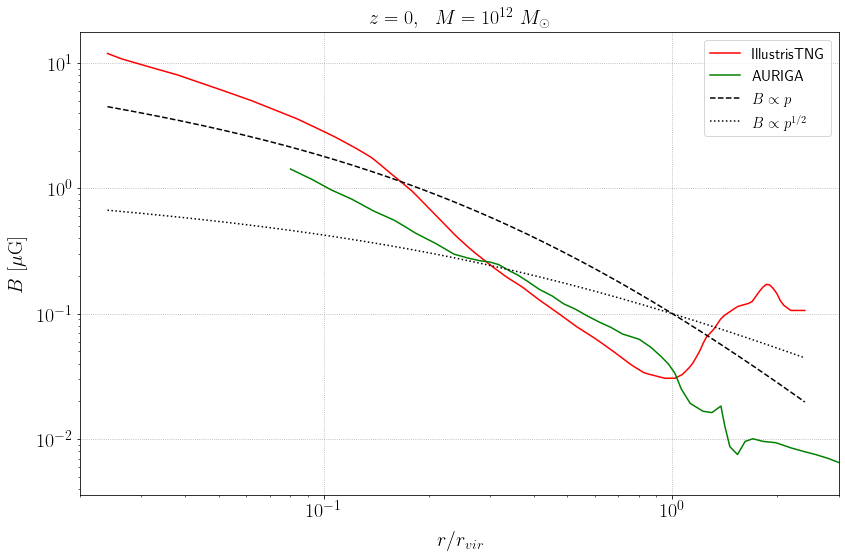

In [230]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
color_list = ['red', 'green', 'blue', 'orange']
r_list = np.logspace(-1.5, 0.5, 200) #np.arange(-1.8, 0.5, 0.01)
r_factor = r200critz[i_z, i_m]/hcos.rvir(ms[i_m],zs[i_z])

bfield_prof_press = (get_pth_profile(r_list*r200critz[i_z, i_m], zs[i_z], m200critz[i_z, i_m], r200critz[i_z, i_m], 
                                     rhocritz[i_z]) / 
                     get_pth_profile(hcos.rvir(ms[i_m],zs[i_z]), zs[i_z], m200critz[i_z, i_m], r200critz[i_z, i_m],
                                     rhocritz[i_z]) )*0.1 
bfield_prof_press_sqrt = (get_pth_profile(r_list*r200critz[i_z, i_m], zs[i_z], m200critz[i_z, i_m], r200critz[i_z, i_m], 
                                          rhocritz[i_z]) / 
                          get_pth_profile(hcos.rvir(ms[i_m],zs[i_z]), zs[i_z], m200critz[i_z, i_m], r200critz[i_z, i_m],
                                          rhocritz[i_z]) )**(1/2) * 0.1

ax.plot(r_list*r_factor, 10**bfield_prof_interp[1](np.log10(r_list)), c='r', label='IllustrisTNG')
ax.plot(bfield_prof_z[0][:, 0]/(r200critz[i_z, i_m]*1000)*r_factor, bfield_prof_z[0][:, 1], c='g', label='AURIGA')
ax.plot(r_list*r_factor, bfield_prof_press, linestyle='dashed', c='k', label=r'$B \propto p$')
ax.plot(r_list*r_factor, bfield_prof_press_sqrt, linestyle='dotted', c='k', label=r'$B \propto p^{1/2}$')
ax.grid(ls=':', color='darkgray', alpha=1)

ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlabel(r'$r/r_{vir}$'); ax.set_ylabel(r'$B\ [\mu \rm{G}]$');
ax.set_xlim(0.02, 3)
ax.set_title(r'$z = 0,\ \  M = 10^{12}\ M_{\odot}$');
ax.legend(ncol=1, loc=1, frameon=True);

fig.tight_layout()
fig.savefig('./figs/Bcomp.pdf', rasterize=True)
fig.savefig('./figs/Bcomp.png', rasterize=True)

In [231]:
bfield_prof_press = []
bfield_prof_press_sqrt = []

for i, z in enumerate(z_list):    
    print(zs[i_z_list[i]])
    bfield_prof_press.append( (get_pth_profile(bfield_prof_z[i][:, 0]/1000, zs[i_z_list[i]], m200critz[i_z_list[i], i_m], r200critz[i_z_list[i], i_m], 
                                         rhocritz[i_z_list[i]]) / 
                         get_pth_profile(r_vir_list[i]/1000, zs[i_z_list[i]], m200critz[i_z_list[i], i_m], r200critz[i_z_list[i], i_m],
                                         rhocritz[i_z_list[i]]) )*0.1 )
    bfield_prof_press_sqrt.append( (get_pth_profile(bfield_prof_z[i][:, 0]/1000, zs[i_z_list[i]], m200critz[i_z_list[i], i_m], r200critz[i_z_list[i], i_m], 
                                         rhocritz[i_z_list[i]]) / 
                         get_pth_profile(r_vir_list[i]/1000, zs[i_z_list[i]], m200critz[i_z_list[i], i_m], r200critz[i_z_list[i], i_m],
                                         rhocritz[i_z_list[i]]) )**(1/2)*0.1 )

0.005
0.2496938775510204
0.4943877551020408
0.9837755102040816
1.962551020408163
3.5530612244897957


<ipython-input-232-11098d2e037e>:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('./figs/Bauriga.pdf', rasterize=True)
<ipython-input-232-11098d2e037e>:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('./figs/Bauriga.png', rasterize=True)


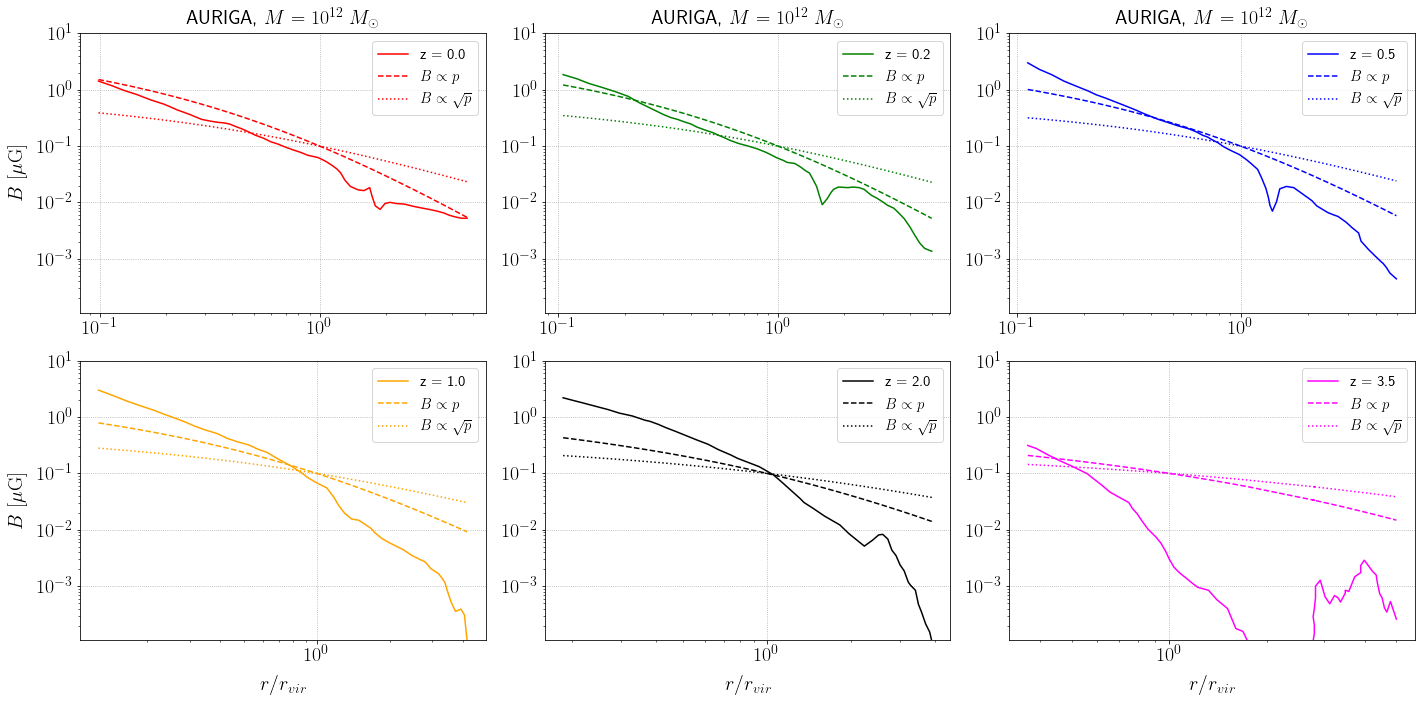

In [232]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
color_list = ['red', 'green', 'blue', 'orange', 'k', 'magenta']

for i, z in enumerate(z_list): 
    row_i = int(np.heaviside(i-3, 1))
    col_i = i%3
    ax[row_i][col_i].plot(bfield_prof_z[i][:, 0]/r_vir_list[i], bfield_prof_z[i][:, 1], label='z = '+str(z), c=color_list[i])
    ax[row_i][col_i].plot(bfield_prof_z[i][:, 0]/r_vir_list[i], bfield_prof_press[i], label=r'$B \propto p$', linestyle='dashed', c=color_list[i])
    ax[row_i][col_i].plot(bfield_prof_z[i][:, 0]/r_vir_list[i], bfield_prof_press_sqrt[i], label=r'$B \propto \sqrt{p}$', linestyle='dotted', c=color_list[i])
    

    ax[row_i][col_i].grid(ls=':', color='darkgray', alpha=1)

    ax[row_i][col_i].set_xscale('log'); ax[row_i][col_i].set_yscale('log');
    ax[row_i][col_i].set_ylim(1.1e-4, 10);
    ax[row_i][col_i].legend(ncol=1, loc=1, frameon=True);
    
    ax[1][col_i].set_xlabel(r'$r/r_{vir}$'); ax[row_i][0].set_ylabel(r'$B\ [\mu \rm{G}]$');
    ax[0][col_i].set_title(r'AURIGA, $M = 10^{12}\ M_{\odot}$');

fig.tight_layout()
fig.savefig('./figs/Bauriga.pdf', rasterize=True)
fig.savefig('./figs/Bauriga.png', rasterize=True)

In [412]:
def get_B_profile(r, m, r200):  
    
    bfield = np.zeros(len(m))
    
    for i, m_val in enumerate(m):
        #print(index)
        i_m = np.digitize(m_val, mvir_bins)
        if i_m >= len(mvir_bins):
            i_m = len(mvir_bins)-1
        bfield[i] = 10**bfield_prof_interp[i_m](np.log10(r[i]/r200[i]) )
        
    return bfield

## Get tau as a function of mass

In [41]:
def get_tau_int_ma(MA, bfield):
    
    # crossing radius in each halo:
    rcross = get_rcross_per_halo(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA)
    
    ucosth, angs = get_halo_skyprofile(zs, chis, rcross)

    # including the B field profile \propto p
    prob = conv_prob_bprof(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA, rcross)
    
    u00 = get_u00(angs, ucosth)
    prob00 = prob * u00

    avtau, dtaudz = get_avtau(zs, ms, nzm, dvols, prob00)
    
    del u00, prob00, prob
    
    # including the B field profile \propto p^(1/2)
    prob = conv_prob_bprof_sqrt(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA, rcross)
    
    u00 = get_u00(angs, ucosth)
    prob00 = prob * u00

    avtau_sqrt, dtaudz_sqrt = get_avtau(zs, ms, nzm, dvols, prob00)

    del u00, prob00, prob

    # constant B field profile    
    prob = old_conv_prob(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA, rcross)

    u00 = get_u00(angs, ucosth)
    prob00 = prob * u00

    avtau_constb, dtaudz_constb = get_avtau(zs, ms, nzm, dvols, prob00)

    del u00, prob00, prob

    return avtau*bfield**2, dtaudz*bfield**2, avtau_sqrt*bfield**2, dtaudz_sqrt*bfield**2, avtau_constb*bfield**2, dtaudz_constb*bfield**2

In [232]:
def get_tau_int_ma_constbfield(MA, bfield):
    
    # crossing radius in each halo:
    rcross = get_rcross_per_halo(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA)
 
    ucosth, angs = get_halo_skyprofile(zs, chis, rcross)

    prob = old_conv_prob(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA, rcross)

    u00 = get_u00(angs, ucosth)
    prob00 = prob * u00

    avtau, dtaudz = get_avtau(zs, ms, nzm, dvols, prob00)

    return avtau*bfield**2, dtaudz*bfield**2

# Results

## Fixed value of MA

In [236]:
############# Define constants ################
# From hmvec:
# proper radius r is always in Mpc
# comoving momentum k is always in Mpc-1
# All masses m are in Msolar
# rho densities are in Msolar/Mpc^3
# No h units anywhere

TFIRAS   = 2.725
TCMB     = 2.725*1e6
cmMpc    = 3.2407792896e-25    # Mpc/cm            # how many Mpc in a cm
eVinvCm  = 1.97*1e-5  #1.2398419e-4        # cm/eV^-1          # how many cm in a eV^-1
mpcEVinv = 1./(cmMpc*eVinvCm)  # eV^-1/Mpc         # how many eV^-1 in a Mpc

msun   = 1.9891e30     # kg               # Sun mass
mprot  = 1.67262e-27   # kg               # Proton mass
m2eV   = 1.4e-21       # eV^2             # conversion factor for plasma mass (eq. (2) in Caputo et al; PRL)
ombh2  = 0.02225                 # Physical baryon density parameter Ωb h2
omch2  = 0.1198                  # Physical dark matter density parameter Ωc h2
conv   = m2eV*(ombh2/omch2)*(msun/mprot)*(cmMpc)**3.

thomson = 0.6652*1e-24
conv2 = thomson*(ombh2/omch2)*(msun/mprot)*(cmMpc)**2.

ev2Joule = lambda ev: 1.602176565*1e-19*ev
K2eV = lambda K: 8.61732814974493*1e-5*K
cligth = 299792458.0 #m/s
hplanck = 6.62607015*1e-34 # m2 kg / s
kboltzmann = 1.380649*1e-23 # m2 kg s-2 K-1
gauss2evsq = lambda gauss: 1.95e-2 * gauss
frq = lambda nu: 100. * nu * cligth

BBf = lambda frq: 1e26/1e6*(2.*frq**3.*hplanck)/cligth**2. / (np.exp(hplanck*frq/kboltzmann/TFIRAS) - 1.)
BBω = lambda omg: (omg**3.)/(2.*np.pi**2.) / (np.exp(omg/K2eV(TFIRAS)) - 1.)

aa = lambda z: 1./(1.+z)

arcmin2rad = lambda arcm: arcm/60. * np.pi/180.
ghztoev    = lambda GHz: 4.13566553853809E-06 * GHz


In [237]:
# Select axion mass in eV
MA = 5e-13

# choose redshift range:
zMin, zMax = 0.005, 6.

# rmin and rmax are the radial limits to scan over in each halo
# need to make sure crossing radius is within these limits
rMin, rMax = 1e-6, 5e1


In [238]:
# how many bins of each: mass, redshift, wavenumber
# to speed things up, you can choose smaller numbers
nMs = 100
nZs = 50
nKs = 1001

# geomspace divides the interval logarithmically and linspace linearly
ms  = np.geomspace(1e11, 1e17, nMs)      # all masses
zs  = np.linspace(zMin, zMax, nZs)       # all redshifts
rs  = np.linspace(rMin, rMax, 100000)    # halo radial coords
ks  = np.geomspace(1e-4, 1e3, nKs)       # all wavenumbers

# Halo Model
hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')

In [ ]:
hcos.rvir(1e12,)

In [29]:
# Useful halo model quantities:

chis     = hcos.comoving_radial_distance(zs)
rvirs    = np.asarray([hcos.rvir(ms,zz) for zz in zs])
cs       = hcos.concentration()
Hz       = hcos.h_of_z(zs)
nzm      = hcos.get_nzm()
biases   = hcos.get_bh()
deltav   = hcos.deltav(zs)
rhocritz = hcos.rho_critical_z(zs)


In [ ]:
dvols  = get_volume_conv(chis, Hz)

# crossing radius in each halo:
rcross = get_rcross_per_halo(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA)

In [ ]:
get_200critz([3.5], [1e12], cs, rhocritz, deltav)

In [373]:
dvols  = get_volume_conv(chis, Hz)

rcross = get_rcross_per_halo_fsolve(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA)

In [203]:
my_test = rcross/rcross_fsolve
my_test[np.abs(my_test-1)>0.01]

array([], dtype=float64)

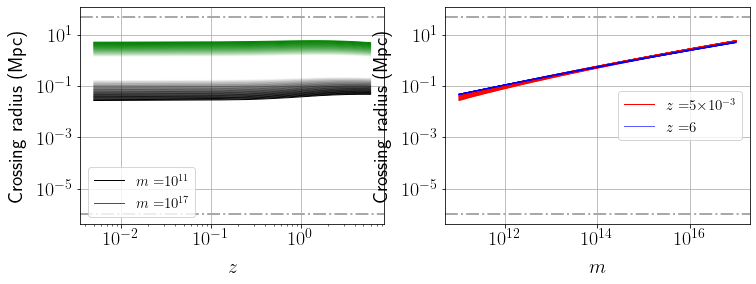

In [206]:
ax1 = plot_dmdz(ms, zs, rcross, count=30, title='Crossing radius (Mpc)')
ax1[0].axhline(rMin, color='darkgray', ls='-.', linewidth=2)
ax1[0].axhline(rMax, color='darkgray', ls='-.', linewidth=2)
ax1[1].axhline(rMin, color='darkgray', ls='-.', linewidth=2)
ax1[1].axhline(rMax, color='darkgray', ls='-.', linewidth=2)
plt.show()


In [114]:
ucosth, angs = get_halo_skyprofile(zs, chis, rcross)

<ipython-input-101-34a746166062>:94: RuntimeWarning: divide by zero encountered in power
  ucosth = (1.-(angs/fract)**2.)**(-0.5)


In [115]:
# Computes probability taking into account inverse of the derivative to trajectory
# See eq. 2.11(A) of https://arxiv.org/pdf/2307.15124.pdf
# It needs a check!!!
# TODO: double checked the expression with Junwu

#prob = old_conv_prob(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA, rcross)

# including the B field profile
prob = conv_prob_bprof(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA, rcross)

# Computes probability with r_cross
# This one is fine works fine

#prob = conv_prob(zs, rvirs, MA, rcross)


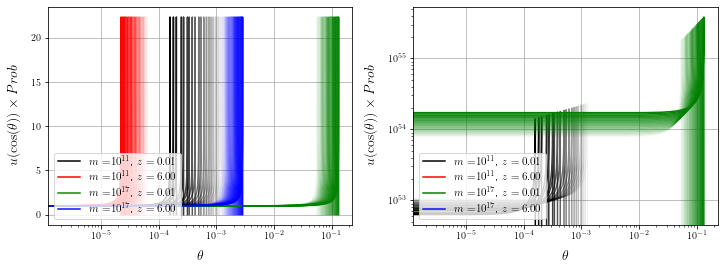

In [116]:
ax = plot_ucosth(ms, zs, angs, ucosth, prob, count=20, title=r'Angular profile $u(\theta)$')
ax[0].set_yscale('linear')
#[aax.set_xscale('linear') for aax in ax]
[aax.legend(loc=3) for aax in ax]; plt.show()


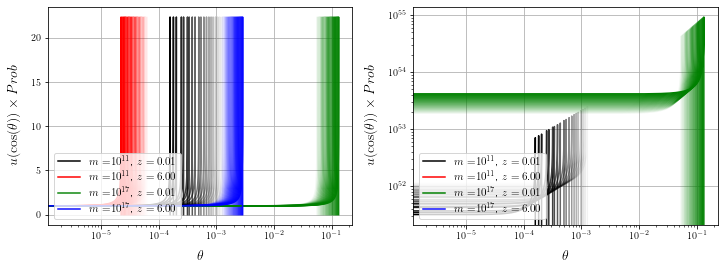

In [15]:
ax = plot_ucosth(ms, zs, angs, ucosth, prob, count=20, title=r'Angular profile $u(\theta)$')
ax[0].set_yscale('linear')
#[aax.set_xscale('linear') for aax in ax]
[aax.legend(loc=3) for aax in ax]; plt.show()


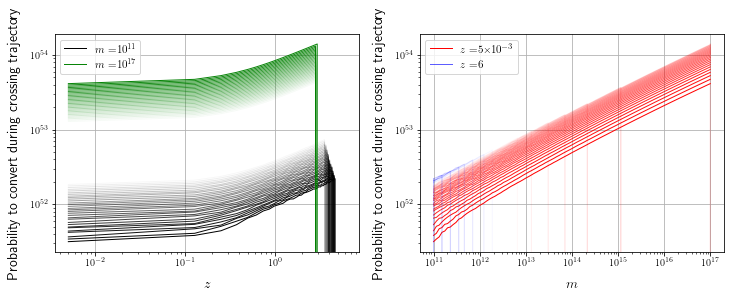

In [17]:
ax = plot_dmdz(ms, zs, prob, count=30, title='Probability to convert during crossing trajectory')
plt.show()

In [117]:
u00 = get_u00(angs, ucosth)
prob00 = prob * u00

avtau, dtaudz = get_avtau(zs, ms, nzm, dvols, prob00)


In [118]:
# photon frequency:
baseline = ghztoev(30) # plug in GHz to get value in eV

# magetic field amp 
bfield = gauss2evsq(1e-7) # plug in G to get value in eV^2

units = baseline * bfield**2.
print(units)


4.717760463087327e-22


In [119]:
print('for axion mass [eV]:', MA, 'monopole magnitude:', avtau)

for axion mass [eV]: 1e-12 monopole magnitude: 6.367948701200033e+53


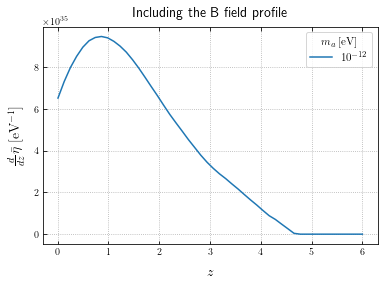

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

lab2 = r'{}'.format(fmt(MA))

ax.plot(zs, dtaudz*bfield**2, ls='-', label=lab2)

ax.set_ylabel(r'$\frac{d}{d z} \bar{\eta} \; [{\rm eV^{-1}}]$')
ax.set_xlabel(r'$z$')

ax.legend(ncol=1, loc=1, title=r'$m_a \, [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")
ax.grid(ls=':', color='darkgray', alpha=1)

ax.set_title('Including the B field profile')

#plt.savefig('./plots/dtaudz.pdf', rasterize=True)
plt.show()


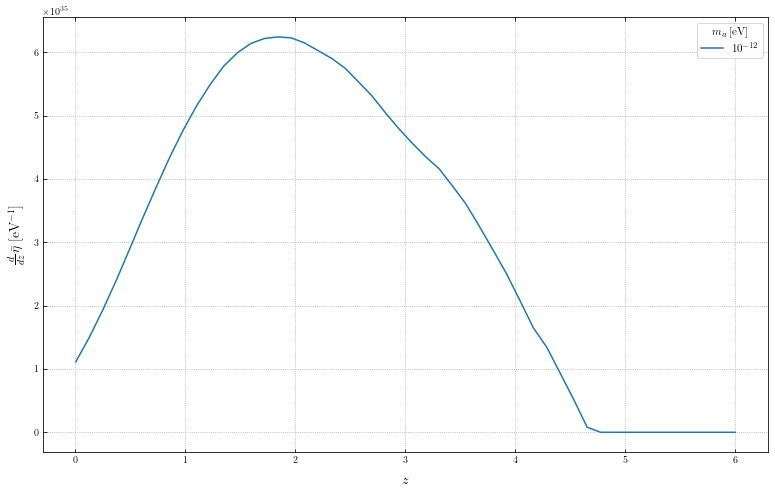

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(13, 8))

lab2 = r'{}'.format(fmt(MA))

ax.plot(zs, dtaudz*units/baseline, ls='-', label=lab2)

ax.set_ylabel(r'$\frac{d}{d z} \bar{\eta} \; [{\rm eV^{-1}}]$')
ax.set_xlabel(r'$z$')

ax.legend(ncol=1, loc=1, title=r'$m_a \, [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")
ax.grid(ls=':', color='darkgray', alpha=1)

#plt.savefig('./plots/dtaudz.pdf', rasterize=True)
plt.show()


## Tau as a function of MA

### Setup

In [209]:
############# Define constants ################
# From hmvec:
# proper radius r is always in Mpc
# comoving momentum k is always in Mpc-1
# All masses m are in Msolar
# rho densities are in Msolar/Mpc^3
# No h units anywhere

TFIRAS   = 2.725
TCMB     = 2.725*1e6
cmMpc    = 3.2407792896e-25    # Mpc/cm            # how many Mpc in a cm
eVinvCm  = 1.97*1e-5  #1.2398419e-4        # cm/eV^-1          # how many cm in a eV^-1
mpcEVinv = 1./(cmMpc*eVinvCm)  # eV^-1/Mpc         # how many eV^-1 in a Mpc

msun   = 1.9891e30     # kg               # Sun mass
mprot  = 1.67262e-27   # kg               # Proton mass
m2eV   = 1.4e-21       # eV^2             # conversion factor for plasma mass (eq. (2) in Caputo et al; PRL)
ombh2  = 0.02225                 # Physical baryon density parameter Ωb h2
omch2  = 0.1198                  # Physical dark matter density parameter Ωc h2
conv   = m2eV*(ombh2/omch2)*(msun/mprot)*(cmMpc)**3.

thomson = 0.6652*1e-24
conv2 = thomson*(ombh2/omch2)*(msun/mprot)*(cmMpc)**2.

ev2Joule = lambda ev: 1.602176565*1e-19*ev
K2eV = lambda K: 8.61732814974493*1e-5*K
cligth = 299792458.0 #m/s
hplanck = 6.62607015*1e-34 # m2 kg / s
kboltzmann = 1.380649*1e-23 # m2 kg s-2 K-1
gauss2evsq = lambda gauss: 1.95e-2 * gauss
frq = lambda nu: 100. * nu * cligth

BBf = lambda frq: 1e26/1e6*(2.*frq**3.*hplanck)/cligth**2. / (np.exp(hplanck*frq/kboltzmann/TFIRAS) - 1.)
BBω = lambda omg: (omg**3.)/(2.*np.pi**2.) / (np.exp(omg/K2eV(TFIRAS)) - 1.)

aa = lambda z: 1./(1.+z)

arcmin2rad = lambda arcm: arcm/60. * np.pi/180.
ghztoev    = lambda GHz: 4.13566553853809E-06 * GHz


In [219]:
# choose redshift range:
zMin, zMax = 0.005, 6.

# rmin and rmax are the radial limits to scan over in each halo
# need to make sure crossing radius is within these limits
rMin, rMax = 1e-7, 5e1


In [220]:
# how many bins of each: mass, redshift, wavenumber
# to speed things up, you can choose smaller numbers
nMs = 200
nZs = 100
nKs = 1001

# geomspace divides the interval logarithmically and linspace linearly
ms  = np.geomspace(1e11, 1e17, nMs)      # all masses
zs  = np.linspace(zMin, zMax, nZs)       # all redshifts
rs  = np.linspace(rMin, rMax, 100000)    # halo radial coords
ks  = np.geomspace(1e-4, 1e3, nKs)       # all wavenumbers

# Halo Model
hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')

In [221]:
# Useful halo model quantities:

chis     = hcos.comoving_radial_distance(zs)
rvirs    = np.asarray([hcos.rvir(ms,zz) for zz in zs])
cs       = hcos.concentration()
Hz       = hcos.h_of_z(zs)
nzm      = hcos.get_nzm()
biases   = hcos.get_bh()
deltav   = hcos.deltav(zs)
rhocritz = hcos.rho_critical_z(zs)


In [222]:
dvols  = get_volume_conv(chis, Hz)

### Computation and plots

In [223]:
#from tqdm.auto import tqdm
from tqdm import tqdm, tqdm_notebook

In [230]:
MA_list = np.array([3e-13, 6e-13, 9e-13, 2e-12]) #np.geomspace(2e-13, 5e-12, 4) 

tau_list = np.zeros((3, len(MA_list)))
dtau_list = np.zeros((3, len(MA_list), len(zs)))

# magetic field amp 
bfield = gauss2evsq(1e-7) # plug in G to get value in eV^2

for i_MA, MA in tqdm(enumerate(MA_list)):
    print(MA)
    tau_list[0, i_MA], dtau_list[0, i_MA], tau_list[1, i_MA], dtau_list[1, i_MA], tau_list[2, i_MA], dtau_list[2, i_MA] = get_tau_int_ma(MA, bfield)

0it [00:00, ?it/s]

3e-13


<ipython-input-208-b220ccd80dfa>:96: RuntimeWarning: divide by zero encountered in power
  ucosth = (1.-(angs/fract)**2.)**(-0.5)
1it [00:12, 12.55s/it]

6e-13


2it [00:24, 12.30s/it]

9e-13


3it [00:35, 12.00s/it]

2e-12


4it [00:45, 11.47s/it]


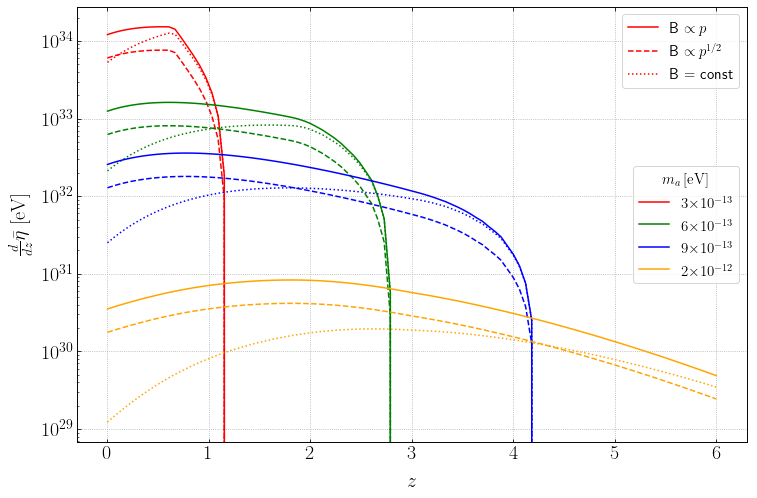

In [247]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
color_list = ['red', 'green', 'blue', 'orange']
ax_mass = []

for i_MA in range(len(MA_list)):
    ax.plot(zs, dtau_list[0, i_MA]*ghztoev(30), ls='solid', label=r'B $\propto p$', c=color_list[i_MA])
    ax.plot(zs, dtau_list[1, i_MA]*ghztoev(30), ls='dashed', label=r'B $\propto p^{1/2}$', c=color_list[i_MA])
    ax.plot(zs, dtau_list[2, i_MA]*ghztoev(30), ls='dotted', label=r'B = const', c=color_list[i_MA])
    #ll, = ax.plot(0,0, c=color_list[i_MA])
    #ax_mass.append(ll[0])
    if i_MA==0:
        ax.legend(ncol=1, loc=1)

        
ax2 = ax.twinx()
for i_MA in range(len(MA_list)):
    ax2.plot(np.NaN, np.NaN, ls='-', label=r'{}'.format(fmt(MA_list[i_MA])), c=color_list[i_MA])
ax2.get_yaxis().set_visible(False)
ax2.legend(loc='center right', title=r'$m_a \, [{\rm eV}]$')

#ax.legend(handles=ax_mass, ['1', '2', '3'])
ax.set_ylabel(r'$\frac{d}{d z} \bar{\eta} \; [{\rm eV}]$')
ax.set_xlabel(r'$z$')
#ax.set_xscale('log'); 
ax.set_yscale('log')

#ax.legend(ncol=1, loc=1, title=r'$m_a \, [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")
ax.grid(ls=':', color='darkgray', alpha=1)

#plt.savefig('./plots/dtaudz.pdf', rasterize=True)
plt.show()


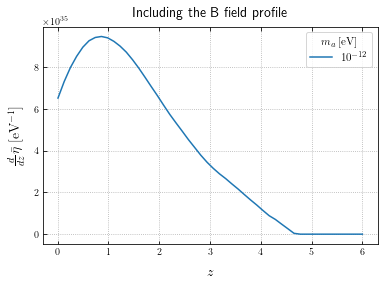

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

lab2 = r'{}'.format(fmt(MA))

ax.plot(zs, dtaudz*bfield**2, ls='-', label=lab2)

ax.set_ylabel(r'$\frac{d}{d z} \bar{\eta} \; [{\rm eV^{-1}}]$')
ax.set_xlabel(r'$z$')

ax.legend(ncol=1, loc=1, title=r'$m_a \, [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")
ax.grid(ls=':', color='darkgray', alpha=1)

ax.set_title('Including the B field profile')

#plt.savefig('./plots/dtaudz.pdf', rasterize=True)
plt.show()


In [150]:
tau_list_nobfield = np.zeros(len(MA_list))

for i_MA, MA in tqdm(enumerate(MA_list)):
    tau_list_nobfield[i_MA] = get_tau_int_ma_constbfield(MA)

0it [00:00, ?it/s]<ipython-input-101-34a746166062>:94: RuntimeWarning: divide by zero encountered in power
  ucosth = (1.-(angs/fract)**2.)**(-0.5)
8it [20:39, 154.97s/it]


In [165]:
MA_list_3 = np.geomspace(2e-13, 1e-11, 3) 
tau_list_3 = np.zeros(len(MA_list_3))

for i_MA, MA in tqdm(enumerate(MA_list_3)):
    tau_list_3[i_MA] = get_tau_int_ma(MA, bfield)

0it [00:00, ?it/s]<ipython-input-101-34a746166062>:94: RuntimeWarning: divide by zero encountered in power
  ucosth = (1.-(angs/fract)**2.)**(-0.5)
3it [08:24, 168.29s/it]


In [170]:
MA_list_3, tau_list_3[:3]

(array([2.00000000e-13, 1.41421356e-12, 1.00000000e-11]),
 array([9.25145545e+37, 1.20216317e+36, 2.34894754e+29]))

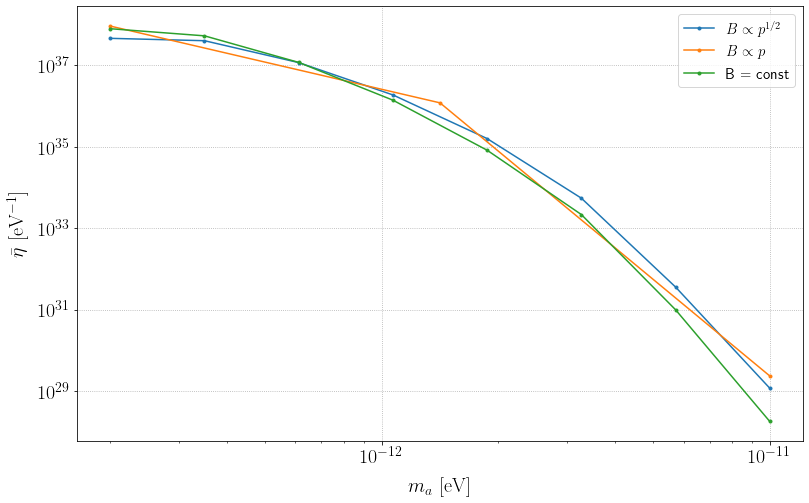

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(13, 8))

ax.plot(MA_list, tau_list, marker='.' ,label=r'$B \propto p^{1/2}$')#, ls='-')
ax.plot(MA_list_3, tau_list_3[:3], marker='.' ,label=r'$B \propto p$')#, ls='-')
ax.plot(MA_list, tau_list_nobfield*bfield**2, marker='.' ,label='B = const')#, ls='-')

ax.set_xlabel(r'$m_a\ [{\rm eV}]$')
ax.set_ylabel(r'$\bar{\eta}\ [{\rm eV^{-1}}]$')

ax.legend()

ax.set_xscale('log'); ax.set_yscale('log')
ax.grid(ls=':', color='darkgray', alpha=1)